In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *
import time 
from statistics import mean
import scipy.linalg as lin
from scipy import signal

In [2]:
def plot_trajectories(x, u, dt, title=""):
    time = np.arange(0, x.shape[1]) * dt
    fig, axs = plt.subplots(5, 1)
    fig.suptitle(title)
    axs[0].plot(time, x[0,:],label='$\Theta$')
    axs[1].plot(time, x[1,:],label='$\dot{\Theta}$')
    axs[2].plot(time, x[2,:],label='$x$')
    axs[3].plot(time, x[3,:],label='$\dot{x}$')
    axs[4].plot(time[:-1],u,label='$u$') #

    for ax in axs:
        ax.set_xlabel("$t$ [s]")
        ax.grid()
        ax.legend()
    print(f"theta at end of {title} = {x[0,-1]} ")

In [3]:
def rk4(system,dt):
    """
    Discretisation of the continuous system using Runge-Kutta 4 discretisation scheme
    
    Inputs:    
    i.system :The Casadi function describing the system
    ii. dt: step size/sampling time
    
    Outputs:
    i. rksys : Discretised system (as a Casadi function)
    """    
    k1 = system(x,u)
    k2 = system(x+dt/2*k1,u)
    k3 = system(x+dt/2*k2,u)
    k4 = system(x+dt*k3,  u)
    xf = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    rksys = Function("Discrete_System",[x,u],[xf])
    return rksys

In [4]:
def lqr(system,Q,R,x,u,dt):
    xdot = system(x,u)
    nx = x.shape[0]
    nu = u.shape[0]

    A_fun = Function('Linearized_A',[x,u],[jacobian(xdot,x)])
    B_fun = Function('Linearized_B',[x,u],[jacobian(xdot,u)])

    xs = np.zeros([nx,1])
    us = np.zeros([nu,1])

    A = A_fun(xs,us)
    B = B_fun(xs,us)
    C = np.eye(nx)
    D = np.zeros([nx,nu])

    sys = signal.StateSpace(A,B,C,D)
    sys_d = sys.to_discrete(dt=dt)
    A_d = sys_d.A
    B_d = sys_d.B

    P = lin.solve_discrete_are(A_d,B_d,Q,R)

    return P

In [5]:
def Optimize_fcn(T,nx,nu,system,u,x,h, solver="ipopt",verbose=False,state_constraint=True, input_constraint=True):
    """
    Function that creates and returns an optimization solver for the optimization problem defined as:
    
    minimize     sum_{k=0}^{N-1} x(k).T*Q*x(k) + u(k).T*R*u(k) + x.T*Qt*x
     x,u
    
    Input arguments: 
    i. T : Prediction horizon (Number of seconds to predict ahead)
    ii. nx : Number of states 
    iii. nu : Number of inputs
    iv. system: The casadi function of the continuous system
    v. x : Casadi symbolic variable representing the states
    vi. u : Casadi symbolic variable representing the input
    vii. h : Sampling rate
    
    Output:
    i. solver : The OCP solver object
    ii. lbw: Lower bound of constraints on the decision variables (State and input here)
    iii. ubw: Upper bound of the constraints on the decision variables
    """

    N = int(T/h)

    #Weighting parameters Q, R and Qt
    Q = np.diag([1e2, 1, 100, 1]) # theta [-3,3], thetadot , x [-0.4, 0.4], xdot []
    r = 1
    R = r*np.eye(nu)

    dsys = rk4(system, h)

    Qt = lqr(system,Q,R,x,u,h)

    X = SX.sym('X',(N+1)*nx,1) #Vector to store all states for N time steps
    U = SX.sym('U',N*nu) #Vector to store inputs for N time steps
    
    #Stage cost as a function of current state and input
    stage_cost = x.T@ Q @ x+ u.T @R @ u
    stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

    #Terminal cost as a function of final state
    terminal_cost = x.T @ Qt @ x
    terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

    # state constraints
    lb_st = []
    ub_st = []
    
    # input constraints"
    lb_u = []
    ub_u = []

    G =[] #Constraint list
    J = 0 #Cost function

    #Adding initial condition to the list of constraints
    X0 = SX.sym('x_init', nx)
    g0 =X[0:nx]-X0
    G.append(g0)
    
    for k in range(N):

        #Extracting current, next states and current input from respective vectors

        x_k = X[k*nx:(k+1)*nx,:]
        x_k_plus = X[(k+1)*nx:(k+2)*nx,:]
        u_k = U[k*nu:(k+1)*nu,:] 
        
        #Stage cost
        J += stage_cost_fcn(x_k,u_k)
        
        #Continuity constraint
        xplus = dsys(x_k,u_k) #Predicting the next state of the system using discretised system
        gk = xplus-x_k_plus 
        G.append(gk) #Difference between predicted state and next state in list added to constraint list
        
        #Updating constraints for states and inputs
        if state_constraint:
            lb_st += [-inf,-inf,-0.3,-inf]
            ub_st += [inf, inf, 0.3, inf]
        else:
            lb_st += [-inf,-inf,-inf,-inf]
            ub_st += [inf, inf, inf, inf]


        if input_constraint:
            lb_u += [-23]
            ub_u += [23]
        else:
            lb_u += [-inf]
            ub_u += [inf]
            
    #Terminal cost
    x_n = X[N*nx:]
    J += terminal_cost_fcn(x_n)
    
    if state_constraint:
        lb_st += [-inf,-inf,-0.3,-inf]
        ub_st += [inf, inf, 0.3, inf]
    else:
        lb_st += [-inf,-inf,-inf,-inf]
        ub_st += [inf, inf, inf, inf]

    #Concatenating the required vectors
    lbw = vertcat(*lb_st, *lb_u)
    ubw = vertcat(*ub_st, *ub_u)
    w = vertcat(X,U)

    prob = {"x":w,"f":J,"g":vertcat(*G),'p':X0}

    if solver == "qpoases":
        opts = {"qpsol": "qrqp"}
        #if not verbose:
           #opts["qpsol_options"] = {"printLevel": "none"}
        opt_solver = nlpsol('solver','sqpmethod',prob, opts)
        
    else:
        opts = {'ipopt.tol':1e-2}
        if not verbose:
            opts = {**opts,
                    'ipopt.print_level': 0,
                    'print_time': 0
                   }
        else:
            opts = {**opts,
                    'ipopt.print_level': 5,
                    'print_time': 0
                   }

        opt_solver = nlpsol('solver','ipopt',prob, opts)

    return opt_solver,lbw,ubw


In [14]:
def mpc(x_0,x,u,system,T_sim,dt,T,h):
    """
    MPC Algorithm function with inputs:
    i. x_0 : Initial condition of system 
    ii. x : Casadi symbolic variable representing the states
    iii. u : Casadi symbolic variable representing the input
    iv. system: The casadi function of the continuous system
    v. T_sim : Simulation time in seconds
    vi. dt : Sampling rate of MPC loop
    vii. T : Prediciton horizon in seconds
    viii. h : Sampling rate of Optimal Control Problem (OCP integration rate)
    and outputs:
    i. res_x_mpc : Closed loop state trajectory 
    ii. res_u_mpc : Input trajectory
    """
    res_x_mpc =[x_0]
    res_u_mpc = []
    N_sim = int(T_sim/dt)
    N = int(T/h)

    ocp_steps_per_mpc_iter = int(dt/h)

    dsys_cl = rk4(system, h)
    
    opt_solver,lbw,ubw = Optimize_fcn(x=x, u=u, system=system, T=T, nx=4, nu=1, h=h,
                            verbose=False, state_constraint=True, input_constraint=True)
    

    for i in range(N_sim):
        #Get predicted states for the next 'N' time steps      
        
        if i == 0:
            init_x, init_u = (np.repeat(x_0,N+1,axis=1).T, [0]*N)
            init_guess = np.concatenate((init_x.flatten(), init_u[0:N])) 

        if i>0: #Warmstart
            opt_x_next = np.concatenate((np.delete(opt_x,[0,1,2,3]).reshape(N,nx),dsys_cl(opt_x[N,:],opt_u[N-1]).full().reshape(1,nx)),axis=0).reshape(N+1,nx)
            opt_u_next = np.concatenate((np.delete(opt_u,0),opt_u[N-1]),axis=0).reshape(N,1) 
            init_guess = vertcat(*opt_x_next,*opt_u_next)            
            

        sol = opt_solver(x0=init_guess, p=x_0,lbx=lbw,ubx=ubw,lbg=0,ubg=0) 
   
        opt_x = sol['x'][:(N+1)*nx].full().reshape(N+1, nx)
        opt_u = sol['x'][(N+1)*nx:].full().reshape(N, nu)
            
        #if not opt_solver.stats()["success"]:
        #    print('OCP not solved') # it doesn't necessarily mean that the OCP is infesible, just that ipopt wasn't capable of finding a solution
        #else:
        #    print("OCP solved")
                        
        #Extract first inputs from optimal inputs and apply to system
        u_k = opt_u[0:ocp_steps_per_mpc_iter]
        for u_i in u_k:
            x_0 = dsys_cl(x_0,u_i).full().reshape(nx,1)
        
            #Append the relevant values to lists
            res_x_mpc.append(x_0)
            res_u_mpc.append(u_i)


    #Concatenate the relevant arrays:
    res_x_mpc = np.concatenate(res_x_mpc,axis=1)
    res_u_mpc = np.array(res_u_mpc) #Create a numpy array from list
    
    #print(f"Average time taken for optimization is {T} seconds")
    return res_x_mpc, res_u_mpc


Time taken for MPC algorithm to simulate 5 seconds is 1.601168400000006 seconds
theta at end of MPC = -5.657893200430923e-05 


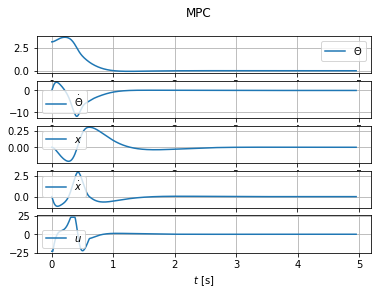

In [15]:

#__________________________________________________ System Definition___________________________________________________________

# Timestep
h = 1/125 # OCP integration time
T = 1.5 # OCP horizon in seconds
dt = 1/12.5 # Closed loop sampling time
T_sim = 5 # Closed loop simulation time


# Constants in SI units

g = 9.81
l = 0.41
b = 0.016
m = 0.3

# Dimensions of x and u:
nx = 4
nu = 1

# Symbolic variables x and u:
x = SX.sym('x', nx)
u = SX.sym('u', nu)

# right hand side of ODE:
xdot = vertcat(
    x[1],
    (3*g/(2*l))*np.sin(x[0]) - (3*b/(m*l**2))*x[1] + 3/(2*l)*np.cos(x[0])*u,
    x[3],
    u   
)


# Create the CasADi function
system = Function("sys",[x,u],[xdot])
x_0 = np.array([pi,0,0,0]).reshape(nx,1)

ta = time.perf_counter()
x_mpc,u_mpc= mpc(x_0,x,u,system,T_sim,dt,T,h)
tb = time.perf_counter()


print(f"Time taken for MPC algorithm to simulate {T_sim} seconds is {tb-ta} seconds")
plot_trajectories(x_mpc, u_mpc, h, title="MPC")
plt.show()